Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


## Identifying Duplicate Questions

In [1]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/Users/vickichen/Desktop/NLP/mini-project-V/train.csv")
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

### Exploration

In [4]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [5]:
#display the rows with null values
mask = df.isnull().any(axis=1)
null_rows=df.loc[mask,:]
null_df=pd.DataFrame(null_rows)
print(null_df)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [6]:
#drop the rows with null values
df.dropna(inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404287 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404287 non-null  int64 
 1   qid1          404287 non-null  int64 
 2   qid2          404287 non-null  int64 
 3   question1     404287 non-null  object
 4   question2     404287 non-null  object
 5   is_duplicate  404287 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


In [8]:
df.shape

(404287, 6)

Is data imbalanced?

In [9]:
df['is_duplicate'].value_counts()

0    255024
1    149263
Name: is_duplicate, dtype: int64

In [10]:
df['is_duplicate'].value_counts(normalize=True)

0    0.630799
1    0.369201
Name: is_duplicate, dtype: float64

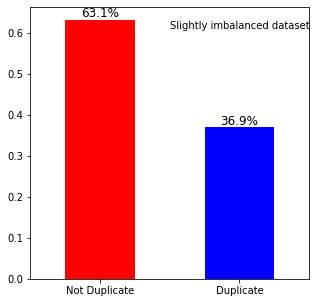

In [11]:
#calculate the proportion of duplicate and non-duplicate questions
proportions = df['is_duplicate'].value_counts(normalize=True)
#set the figure size
plt.figure(figsize=(5,5))
#plot the bar chart
proportions.plot(kind='bar',color=['red','blue'])
# add text labels to the top of the bars
for p in plt.gca().patches:
    plt.gca().text(p.get_x() + p.get_width()/2., p.get_height(), '{:.1f}%'.format(100*p.get_height()), 
                   fontsize=12, ha='center', va='bottom')
#set the tick labels of the x-axis
plt.xticks([0,1],['Not Duplicate','Duplicate'],rotation=0)
# Add a label indicating the imbalanced nature of the dataset
plt.text(0.5, 0.95, 'Slightly imbalanced dataset', ha='left', va='top', transform=plt.gca().transAxes)
#show the plot
plt.show()


In [12]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [13]:
# Unique questions ids in the training set
unique_ids = len(set(df['qid1'].tolist() + df['qid2'].tolist()))
print("Number of unique questions ids in the training data: {}".format(unique_ids))
# Number of duplicate questions in the training set
duplicate_ques = pd.Series(df['question1'].tolist()+df['question2'].tolist()).value_counts()>1
print("Number of duplicate questions in the training data: {}".format(sum(duplicate_ques)))
# Number of questions that appear only once
unique_questions =pd.Series(df['question1'].tolist()+df['question2'].tolist()).value_counts()==1
print("Number of questions that appear only once in the training data: {}".format(sum(unique_questions)))


Number of unique questions ids in the training data: 537929
Number of duplicate questions in the training data: 111870
Number of questions that appear only once in the training data: 425489


#### Plot hist. for the repeated questions and find the max number of times a single question is repeated. 

In [14]:
questions_list= pd.concat([df['question1'],df['question2']])
duplicate_questions = questions_list.value_counts()[questions_list.value_counts()>1]
duplicate_questions.head(10)


What are the best ways to lose weight?                                                                161
How can you look at someone's private Instagram account without following them?                       120
How can I lose weight quickly?                                                                        111
What's the easiest way to make money online?                                                           88
Can you see who views your Instagram?                                                                  79
What are some things new employees should know going into their first day at AT&T?                     77
What do you think of the decision by the Indian Government to demonetize 500 and 1000 rupee notes?     68
Which is the best digital marketing course?                                                            66
How can you increase your height?                                                                      63
How do l see who viewed my videos on Instagram

Maximum number of times a single question is repeated: 161


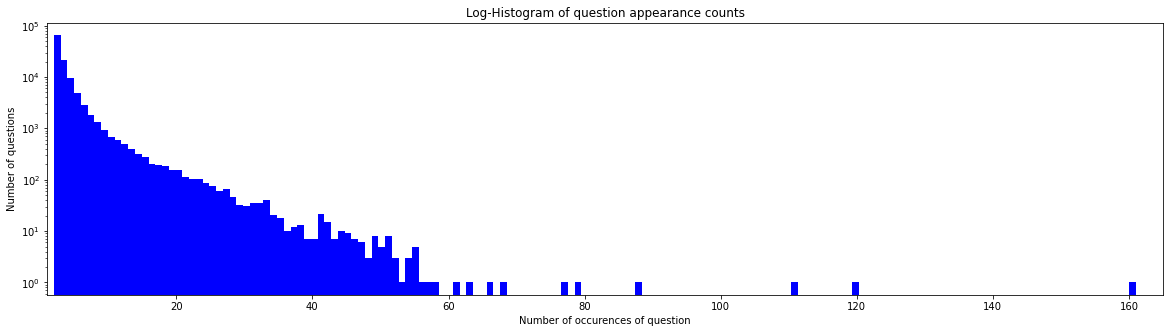

In [15]:
plt.figure(figsize=(20, 5))
duplicate_ques=duplicate_ques.astype(int)
plt.hist(duplicate_questions, bins=160, color='blue', log=True)
plt.yscale('log')
plt.xlim(1, 165)
plt.title("Log-Histogram of question appearance counts")
plt.xlabel("Number of occurences of question")
plt.ylabel("Number of questions")
print("Maximum number of times a single question is repeated: {}".format(max(duplicate_questions)))
plt.show()

### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [16]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []
   
    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q 

In [17]:
%%time
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)
print("Train data text preprocessing done")



/Users/vickichen/opt/anaconda3/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


Train data text preprocessing done
CPU times: user 1min 31s, sys: 333 ms, total: 1min 31s
Wall time: 1min 31s


In [18]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0


In [19]:
# saving the preprocessed data to a new csv file
df.to_csv('/Users/vickichen/Desktop/NLP/mini-project-V/train_preprocessed.csv', index=False)

### The kernel is running out of memory and keep crashing . Dataset is too large. Going to take 30000 random data only from new csv file. 

In [20]:
new_df = pd.read_csv('/Users/vickichen/Desktop/NLP/mini-project-V/train_preprocessed.csv')
new_df = df.sample(30000,random_state=2)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
331535,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1
45407,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1
286200,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0
157195,157195,245856,245857,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...,1
154346,154346,242075,242076,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,1


### Apply Lemmatization

In [21]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
lemmatizer=WordNetLemmatizer()
def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(w) for w in text.split()])
new_df['question1_lemmatization'] = new_df['question1'].apply(lambda text:lemmatize_text(text))
new_df['question2_lemmatization'] = new_df['question2'].apply(lambda text:lemmatize_text(text))
new_df.head()


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vickichen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,id,qid1,qid2,question1,question2,is_duplicate,question1_lemmatization,question2_lemmatization
331535,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1,how can i learn norwegian,what is the quickest way to learn norwegian
45407,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1,how are currency rate determined,where and how are exchange rate determined
286200,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0,what is substitution,what is a substitute for caciocavallo
157195,157195,245856,245857,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...,1,how can i make iphone 4 faster with io 9 2,i have an iphone 4 how do i make it faster and...
154346,154346,242075,242076,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,1,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...


In [22]:
from nltk.corpus import stopwords
# merge texts
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(new_df['question1_lemmatization']) + list(new_df['question2_lemmatization'])


In [23]:
cv = CountVectorizer(max_features=10000)
q=cv.fit_transform(questions)

In [24]:
q1_arr = q[:(q.shape[0]//2),]

In [25]:
q2_arr = q[(q.shape[0]//2):,]

In [26]:
q1_arr.shape[0]+q2_arr.shape[0]

60000

In [27]:
q1_arr.shape, q2_arr.shape

((30000, 10000), (30000, 10000))

In [28]:
from scipy.sparse import hstack
q_arr = hstack((q1_arr, q2_arr))

In [29]:
q_arr.shape

(30000, 20000)

In [30]:
# train test split, 20% data for testing 
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(q_arr,new_df['is_duplicate'],test_size=0.2,random_state=1)


In [31]:
#logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
lr=LogisticRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
print("Logistic Regression Accuracy Score:",accuracy_score(y_test,y_pred))


Logistic Regression Accuracy Score: 0.7046666666666667


/Users/vickichen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
# random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
print("Random Forest Accuracy Score:",accuracy_score(y_test,y_pred))

Random Forest Accuracy Score: 0.7395


In [33]:
# xgboost
from xgboost import XGBClassifier
xbg = XGBClassifier()
xbg.fit(X_train,y_train)
y_pred=xbg.predict(X_test)
accuracy_score(y_test,y_pred)

0.729

### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [34]:
new_df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'question1_lemmatization', 'question2_lemmatization'],
      dtype='object')

## Feature creation - add new feature

In [35]:
def feature_extraction(q):
    q =q.str.len()

In [36]:
#Find the questions length
new_df['question1_len'] = new_df['question1_lemmatization'].str.len()
new_df['question2_len'] = new_df['question2_lemmatization'].str.len()

In [37]:
#Find the number of words in each question
new_df['question1_num_words'] = new_df['question1_lemmatization'].apply(lambda row : len(row.split(" ")))
new_df['question2_num_words'] = new_df['question2_lemmatization'].apply(lambda row : len(row.split(" ")))
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_lemmatization,question2_lemmatization,question1_len,question2_len,question1_num_words,question2_num_words
331535,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1,how can i learn norwegian,what is the quickest way to learn norwegian,25,43,5,8
45407,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1,how are currency rate determined,where and how are exchange rate determined,32,42,5,7
286200,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0,what is substitution,what is a substitute for caciocavallo,20,37,3,6
157195,157195,245856,245857,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...,1,how can i make iphone 4 faster with io 9 2,i have an iphone 4 how do i make it faster and...,42,70,11,16
154346,154346,242075,242076,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,1,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,57,62,11,12


In [38]:
#Find the number of common words in each question
def common_words(row):
    return len(set(row['question1_lemmatization'].split()).intersection(set(row['question2_lemmatization'].split())))
new_df['common_words'] = new_df.apply(common_words, axis=1)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_lemmatization,question2_lemmatization,question1_len,question2_len,question1_num_words,question2_num_words,common_words
331535,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1,how can i learn norwegian,what is the quickest way to learn norwegian,25,43,5,8,2
45407,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1,how are currency rate determined,where and how are exchange rate determined,32,42,5,7,4
286200,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0,what is substitution,what is a substitute for caciocavallo,20,37,3,6,2
157195,157195,245856,245857,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...,1,how can i make iphone 4 faster with io 9 2,i have an iphone 4 how do i make it faster and...,42,70,11,16,6
154346,154346,242075,242076,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,1,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,57,62,11,12,8


In [39]:
#find total number of words in each question
def total_words(row):
    return len(set(row['question1_lemmatization'].split()).union(set(row['question2_lemmatization'].split())))
new_df['total_words'] = new_df.apply(total_words, axis=1)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_lemmatization,question2_lemmatization,question1_len,question2_len,question1_num_words,question2_num_words,common_words,total_words
331535,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1,how can i learn norwegian,what is the quickest way to learn norwegian,25,43,5,8,2,11
45407,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1,how are currency rate determined,where and how are exchange rate determined,32,42,5,7,4,8
286200,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0,what is substitution,what is a substitute for caciocavallo,20,37,3,6,2,7
157195,157195,245856,245857,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...,1,how can i make iphone 4 faster with io 9 2,i have an iphone 4 how do i make it faster and...,42,70,11,16,6,20
154346,154346,242075,242076,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,1,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,57,62,11,12,8,15


In [40]:
# find word share
new_df['word_share'] = round(new_df['common_words'] / new_df['total_words'],2)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_lemmatization,question2_lemmatization,question1_len,question2_len,question1_num_words,question2_num_words,common_words,total_words,word_share
331535,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1,how can i learn norwegian,what is the quickest way to learn norwegian,25,43,5,8,2,11,0.18
45407,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1,how are currency rate determined,where and how are exchange rate determined,32,42,5,7,4,8,0.50
286200,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0,what is substitution,what is a substitute for caciocavallo,20,37,3,6,2,7,0.29
157195,157195,245856,245857,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...,1,how can i make iphone 4 faster with io 9 2,i have an iphone 4 how do i make it faster and...,42,70,11,16,6,20,0.30
154346,154346,242075,242076,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,1,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,57,62,11,12,8,15,0.53


## Let's do some plots to analysis of features 

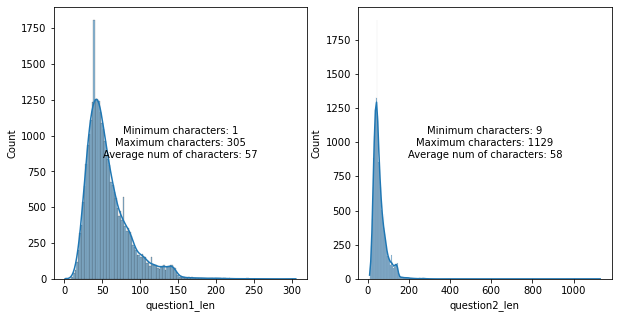

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Use histplot to plot the data in the first subplot
sns.histplot(new_df['question1_len'], kde=True, ax=ax1)

# Add text annotations to the first subplot
min_val = new_df['question1_len'].min()
max_val = new_df['question1_len'].max()
mean_val = int(new_df['question1_len'].mean())
ax1.text(0.5, 0.5, f"Minimum characters: {min_val}\nMaximum characters: {max_val}\nAverage num of characters: {mean_val}", 
         transform=ax1.transAxes, ha="center", va="center")

# Use histplot to plot the data in the second subplot
sns.histplot(new_df['question2_len'], kde=True, ax=ax2)

# Add text annotations to the second subplot
min_val = new_df['question2_len'].min()
max_val = new_df['question2_len'].max()
mean_val = int(new_df['question2_len'].mean())
ax2.text(0.5, 0.5, f"Minimum characters: {min_val}\nMaximum characters: {max_val}\nAverage num of characters: {mean_val}", 
         transform=ax2.transAxes, ha="center", va="center")

# Show the plot
plt.show()


/Users/vickichen/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/vickichen/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


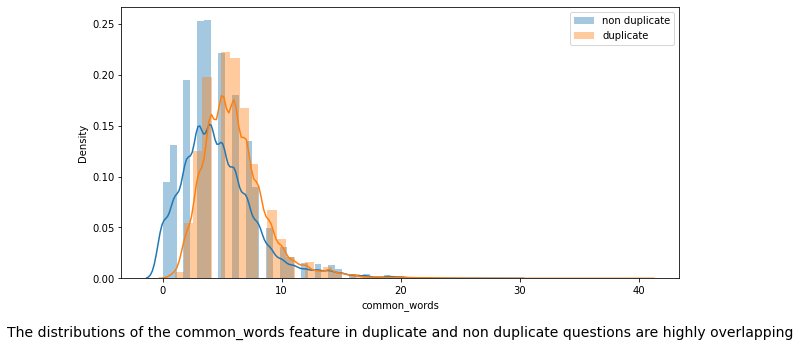

In [42]:
# Create a figure and a subplot
fig, ax = plt.subplots(figsize=(10, 5))

# Use distplot to plot the data for the non-duplicate rows
sns.distplot(new_df[new_df['is_duplicate'] == 0]['common_words'], label='non duplicate')

# Use distplot to plot the data for the duplicate rows
sns.distplot(new_df[new_df['is_duplicate'] == 1]['common_words'], label='duplicate')

# Add a legend to the plot
plt.legend()

# Add text annotations to the plot
text = "The distributions of the common_words feature in duplicate and non duplicate questions are highly overlapping"
ax.text(0.5, -0.2, text, transform=ax.transAxes, ha="center", va="center", fontsize=14)

# Show the plot
plt.show()

/Users/vickichen/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/vickichen/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


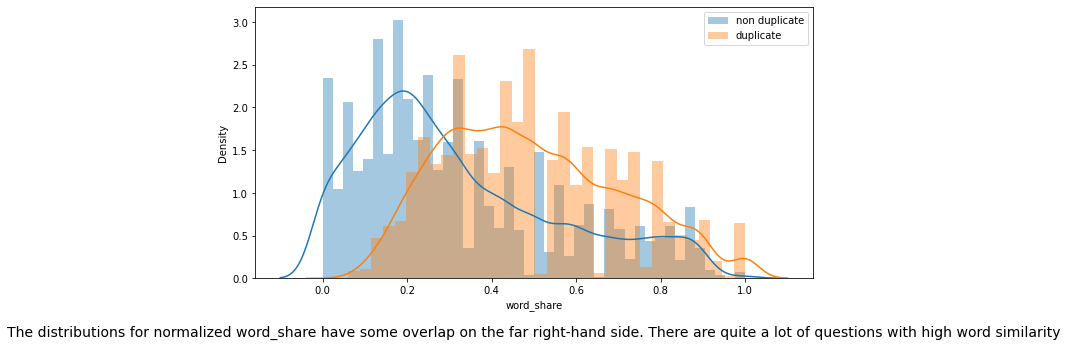

In [43]:
# Create a figure and a subplot
fig, ax = plt.subplots(figsize=(10, 5))

# Use distplot to plot the data for the non-duplicate rows
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_share'], label='non duplicate')

# Use distplot to plot the data for the duplicate rows
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_share'], label='duplicate')

# Add a legend to the plot
plt.legend()

# Add text annotations to the plot
text = "The distributions for normalized word_share have some overlap on the far right-hand side. There are quite a lot of questions with high word similarity"
ax.text(0.5, -0.2, text, transform=ax.transAxes, ha="center", va="center", fontsize=14)

# Show the plot
plt.show()


/Users/vickichen/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/vickichen/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


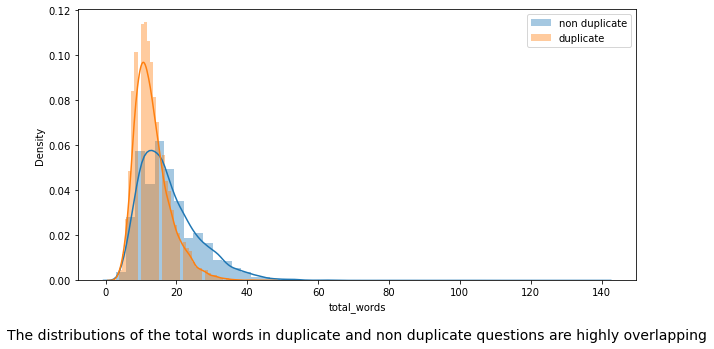

In [44]:
# Create a figure and a subplot
fig, ax = plt.subplots(figsize=(10, 5))

#use distplot to plot total words
sns.distplot(new_df[new_df['is_duplicate'] == 0]['total_words'], label='non duplicate')
sns.distplot(new_df[new_df['is_duplicate'] == 1]['total_words'], label='duplicate')


# Add a legend to the plot
plt.legend()

# Add text annotations to the plot
text = "The distributions of the total words in duplicate and non duplicate questions are highly overlapping"
ax.text(0.5, -0.2, text, transform=ax.transAxes, ha="center", va="center", fontsize=14)

# Show the plot
plt.show()



In [45]:
# make a copy of the dataframe
df_new=new_df.copy()

In [46]:
final_df=df_new.drop(['id','qid1','qid2','question1','question2','question1_lemmatization','question2_lemmatization'],axis=1)
print(final_df.shape)
final_df.head()

(30000, 8)


,is_duplicate,question1_len,question2_len,question1_num_words,question2_num_words,common_words,total_words,word_share
331535,1,25,43,5,8,2,11,0.18
45407,1,32,42,5,7,4,8,0.50
286200,0,20,37,3,6,2,7,0.29
157195,1,42,70,11,16,6,20,0.30
154346,1,57,62,11,12,8,15,0.53


In [47]:
new_df=new_df.drop(['question1','question2'],axis=1)
new_df

,id,qid1,qid2,is_duplicate,question1_lemmatization,question2_lemmatization,question1_len,question2_len,question1_num_words,question2_num_words,common_words,total_words,word_share
331535,331535,169053,295926,1,how can i learn norwegian,what is the quickest way to learn norwegian,25,43,5,8,2,11,0.18
45407,45407,81383,81384,1,how are currency rate determined,where and how are exchange rate determined,32,42,5,7,4,8,0.50
286200,286200,285024,406729,0,what is substitution,what is a substitute for caciocavallo,20,37,3,6,2,7,0.29
157195,157195,245856,245857,1,how can i make iphone 4 faster with io 9 2,i have an iphone 4 how do i make it faster and...,42,70,11,16,6,20,0.30
154346,154346,242075,242076,1,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,57,62,11,12,8,15,0.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91979,91979,154061,154062,0,is it possible that srk is bisexual or not,is lady gaga actually bisexual,42,30,9,5,2,11,0.18
125045,125045,176974,56684,1,why do you think people fall in love,how do people fall in love,36,26,8,6,5,9,0.56
313995,313995,438653,438654,0,how do i isolate a in f d e a b c,what is the minimized form of this logic expre...,33,85,12,24,5,30,0.17
203571,203571,306230,220388,0,what is the function of e commerce,is e commerce model sustainable,34,31,7,5,3,9,0.33


In [48]:
#merge texts 
from sklearn.feature_extraction.text import CountVectorizer
questions = list(new_df['question1_lemmatization']) + list(new_df['question2_lemmatization'])


In [49]:
cv = CountVectorizer(max_features=3000)
q1_arr,q2_arr =np.vsplit(cv.fit_transform(questions).toarray(),2)

In [50]:
temp_df1=pd.DataFrame(q1_arr,index=new_df.index)
temp_df2=pd.DataFrame(q2_arr,index=new_df.index)
temp_df=pd.concat([temp_df1,temp_df2],axis=1)
temp_df.shape

(30000, 6000)

In [51]:
temp_df

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
331535,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45407,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
286200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
157195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154346,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91979,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
125045,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
313995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
203571,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
temp_df['is_duplicate']=new_df['is_duplicate']

In [53]:
nan_rows = temp_df[temp_df.isnull().T.any().T]
nan_rows

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,is_duplicate


In [54]:
temp_df

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,is_duplicate
331535,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
45407,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
286200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
157195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
154346,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91979,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
125045,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
313995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
203571,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
final_df=pd.concat([final_df,temp_df],axis=1)

In [56]:
final_df.head()

,is_duplicate,question1_len,question2_len,question1_num_words,question2_num_words,common_words,total_words,word_share,0,1,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,is_duplicate
331535,1,25,43,5,8,2,11,0.18,0,0,...,0,0,0,0,0,0,0,0,0,1
45407,1,32,42,5,7,4,8,0.50,0,0,...,0,0,0,0,0,0,0,0,0,1
286200,0,20,37,3,6,2,7,0.29,0,0,...,0,0,0,0,0,0,0,0,0,0
157195,1,42,70,11,16,6,20,0.30,0,0,...,0,0,0,0,0,0,0,0,0,1
154346,1,57,62,11,12,8,15,0.53,0,0,...,0,0,0,0,0,0,0,0,0,1


## Modeling added new features added 

In [57]:
#20% of data for testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values, test_size=0.2, random_state=1)

In [58]:
import sklearn.metrics as metrics
#logistic regression
lr=LogisticRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
print("Logistic Regression Accuracy Score:",metrics.accuracy_score(y_test, y_pred))

#Random Forest
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
print("Random Forest Accuracy Score:",metrics.accuracy_score(y_test, y_pred))

#XGBoost
xgb=XGBClassifier()
xgb.fit(X_train,y_train)
y_pred=xgb.predict(X_test)
print("XGBoost Accuracy Score:",metrics.accuracy_score(y_test, y_pred))


/Users/vickichen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy Score: 1.0
Random Forest Accuracy Score: 0.9961666666666666
XGBoost Accuracy Score: 1.0


# Use Word2vec

In [59]:
#using word2vec
new_df

,id,qid1,qid2,is_duplicate,question1_lemmatization,question2_lemmatization,question1_len,question2_len,question1_num_words,question2_num_words,common_words,total_words,word_share
331535,331535,169053,295926,1,how can i learn norwegian,what is the quickest way to learn norwegian,25,43,5,8,2,11,0.18
45407,45407,81383,81384,1,how are currency rate determined,where and how are exchange rate determined,32,42,5,7,4,8,0.50
286200,286200,285024,406729,0,what is substitution,what is a substitute for caciocavallo,20,37,3,6,2,7,0.29
157195,157195,245856,245857,1,how can i make iphone 4 faster with io 9 2,i have an iphone 4 how do i make it faster and...,42,70,11,16,6,20,0.30
154346,154346,242075,242076,1,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,57,62,11,12,8,15,0.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91979,91979,154061,154062,0,is it possible that srk is bisexual or not,is lady gaga actually bisexual,42,30,9,5,2,11,0.18
125045,125045,176974,56684,1,why do you think people fall in love,how do people fall in love,36,26,8,6,5,9,0.56
313995,313995,438653,438654,0,how do i isolate a in f d e a b c,what is the minimized form of this logic expre...,33,85,12,24,5,30,0.17
203571,203571,306230,220388,0,what is the function of e commerce,is e commerce model sustainable,34,31,7,5,3,9,0.33


In [60]:
import gensim
from gensim.models import Word2Vec

In [61]:
def read_questions(row,column_name):
    return gensim.utils.simple_preprocess(str(row[column_name]).encode('utf-8'))
    
documents = []
for index, row in new_df.iterrows():
    documents.append(read_questions(row,"question1_lemmatization"))
    if row["is_duplicate"] == 0:
        documents.append(read_questions(row,"question2_lemmatization"))

In [62]:
w2v_model = Word2Vec(min_count=10,
                     window=3,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=4)

### min_count: The minimum number of times a word must appear in the data to be included in the vocabulary. Words that appear fewer times are discarded.
### window: The maximum distance between the current and predicted word within a sentence.
### vector_size: The dimensionality of the word vectors.
### sample: The threshold for subsampling frequent words.
### alpha: The initial learning rate.
### min_alpha: The minimum learning rate.
### negative: The number of negative samples to use.
### workers: The number of worker threads to use.

In [63]:
## build the vocabulary
w2v_model.build_vocab(documents, progress_per=10000)

In [64]:
## train the model
w2v_model.train(documents, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(5270614, 15683970)

In [65]:
# creating a list of words from the trained w2v_model object, 
# which is an instance of the Word2Vec class from the gensim library
words = list(w2v_model.wv.key_to_index)

In [66]:
#calling the most_similar method on the wv attribute of the w2v_model object
#Example: most similar words to China
w2v_model.wv.most_similar(positive=["china"])

[('russia', 0.802885890007019),
 ('colonized', 0.729585587978363),
 ('invade', 0.7272735238075256),
 ('pakistan', 0.717477023601532),
 ('invaded', 0.7012987732887268),
 ('declare', 0.698104739189148),
 ('nato', 0.6745947599411011),
 ('israel', 0.674231231212616),
 ('declared', 0.6705490350723267),
 ('ally', 0.6682952046394348)]

In [67]:
splitted = []
for row in questions: 
    splitted.append([word for word in row.split()]) 

In [68]:
avg_data = []
for row in splitted:
    vec = np.zeros(300)
    count = 0
    for word in row:
        try:
            vec = vec+ w2v_model.wv[word]
            count = count+ 1
        except:
            pass
    avg_data.append(vec/count)

/var/folders/fz/ntgp3y9j3p777vzmhx_1fmwr0000gn/T/ipykernel_12974/248333609.py:11: RuntimeWarning: invalid value encountered in true_divide
  avg_data.append(vec/count)


In [69]:
avg_data[0]

array([ 0.05720285,  0.0099289 , -0.17863025,  0.12823828, -0.16562439,
       -0.32621419,  0.02063175,  0.17674623,  0.01856423, -0.31913154,
       -0.282043  , -0.16892226,  0.05737694,  0.08276234,  0.00115552,
        0.00940225, -0.27273954,  0.06722422,  0.22230103, -0.06911482,
        0.30803623, -0.03690525, -0.33670159, -0.04690972, -0.16128254,
        0.02301922, -0.39350346,  0.1887368 ,  0.03144737,  0.04663224,
        0.13188887, -0.07011659,  0.09784662, -0.06853869, -0.12688319,
       -0.30266712,  0.12486   ,  0.05583295,  0.44763652, -0.15667581,
       -0.08394868, -0.06525946, -0.05865091, -0.40941204, -0.12757314,
       -0.09996987,  0.31288234,  0.25368961, -0.20154973,  0.23116091,
       -0.19702735, -0.06688343,  0.09647757,  0.16525273,  0.1269204 ,
        0.1367404 , -0.11575349, -0.12491123,  0.11528361,  0.25770873,
       -0.01173134, -0.20448075, -0.02671187, -0.0233703 , -0.11941044,
        0.31126988,  0.04058002, -0.08162556,  0.140337  , -0.17

In [70]:
length = len(avg_data)
half = int(length/2)
first_half = avg_data[:half]
second_half = avg_data[length-half:]

In [71]:
q1_arry = np.array(first_half)
q2_arry = np.array(second_half)

In [72]:
q1_arry.shape, q2_arry.shape

((30000, 300), (30000, 300))

In [73]:
tem_df1 = pd.DataFrame(q1_arry, index= new_df.index)
tem_df2 = pd.DataFrame(q2_arry, index= new_df.index)
tem_df = pd.concat([tem_df1, tem_df2], axis=1)

In [74]:
finall_df = pd.concat([tem_df, temp_df], axis=1)

In [75]:
finall_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,is_duplicate
331535,0.057203,0.009929,-0.178630,0.128238,-0.165624,-0.326214,0.020632,0.176746,0.018564,-0.319132,...,0,0,0,0,0,0,0,0,0,1
45407,-0.053129,-0.175467,0.205809,0.102046,-0.339266,-0.239534,-0.107314,0.264041,-0.017595,0.065719,...,0,0,0,0,0,0,0,0,0,1
286200,-0.295535,-0.292961,0.221495,0.395912,-0.306045,-0.012087,0.202113,-0.187428,-0.118402,0.142646,...,0,0,0,0,0,0,0,0,0,0
157195,0.197187,0.027628,-0.154314,0.067636,-0.052752,-0.351755,0.101599,0.465621,0.097460,-0.164015,...,0,0,0,0,0,0,0,0,0,1
154346,0.039635,0.238501,-0.008885,-0.006871,0.441459,0.048614,0.091319,0.223568,-0.021686,-0.240730,...,0,0,0,0,0,0,0,0,0,1


In [119]:
finall_df.isnull().sum()

0               10
1               10
2               10
3               10
4               10
                ..
2996             0
2997             0
2998             0
2999             0
is_duplicate     0
Length: 6601, dtype: int64

In [121]:
finall_df.dropna(inplace=True)

In [122]:
finall_df.isnull().sum()

0               0
1               0
2               0
3               0
4               0
               ..
2996            0
2997            0
2998            0
2999            0
is_duplicate    0
Length: 6601, dtype: int64

In [123]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest = train_test_split(finall_df.iloc[:,0:-1].values,finall_df.iloc[:,-1].values,test_size=0.2,random_state=1)

In [127]:
# GridSearchCV to perform a grid search for hyperparameter optimization on a logistic regression mode 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# create a logistic regression model
lr = LogisticRegression()

# specify the hyperparameter grid
param_grid = {'C': [0.1, 1, 10, 100],
              'penalty': ['l1', 'l2']}

# create a grid search object
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5)

# fit the grid search object to the training data
grid_search.fit(Xtrain, ytrain)

# print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# predict on the test set and print the accuracy
y_pred = grid_search.predict(Xtest)
print("Logistic Regression Accuracy:", metrics.accuracy_score(ytest, y_pred))


/Users/vickichen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vickichen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vickichen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vickichen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Best hyperparameters: {'C': 0.1, 'penalty': 'l2'}
Accuracy: 0.7255751917305768


/Users/vickichen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [129]:
#This will perform 5-fold cross-validation on the logistic regression model
#with the best hyperparameters found by the grid search,
from sklearn.model_selection import cross_val_score

# create a logistic regression model
lr = LogisticRegression()

# specify the hyperparameter grid
param_grid = {'C': [0.1, 1, 10, 100],
              'penalty': ['l1', 'l2']}

# create a grid search object
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5)

# fit the grid search object to the training data
grid_search.fit(Xtrain, ytrain)

# print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# get the best model
best_model = grid_search.best_estimator_

# calculate the cross-validation scores
scores = cross_val_score(best_model, Xtest, ytest, cv=5)

# print the mean and standard deviation of the scores
print("Logistic Regression Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


/Users/vickichen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vickichen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/vickichen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vickichen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Best hyperparameters: {'C': 0.1, 'penalty': 'l2'}
Logistic Regression Accuracy: 0.70 (+/- 0.02)


In [125]:
#from xgboost import XGBClassifier
#xgb = XGBClassifier(n_estimators=200,n_jobs=4, max_depth=30, learning_rate=0.1, subsample = 0.5)
#xgb.fit(Xtrain,ytrain)
#y_pred = xgb.predict(Xtest)
#accuracy_score(ytest,y_pred)

In [ ]:
#Random Forest with GridSearch
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Create the grid search object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy',error_score='raise')

# Fit the grid search to the data
grid_search.fit(Xtrain, ytrain)

# Print the best parameters
print(grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(Xtest)

# Calculate the accuracy
accuracy = metrics.accuracy_score(ytest, y_pred)
print("Random Forest Accuracy:", accuracy)


In [128]:
# Gridsearch Random Forest with Cross -Validatin 
from sklearn.model_selection import cross_val_score

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Create the grid search object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(Xtrain, ytrain)

# Print the best parameters
print(grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Calculate the cross-validation scores
scores = cross_val_score(best_model, Xtest, ytest, cv=5, scoring='accuracy')

# Print the mean and standard deviation of the cross-validation scores
print("Random Forest Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 30}
Accuracy: 0.69 (+/- 0.02)


the cross-validation scores are a measure of how well the model is performing on the test set. The mean of the scores, 0.69 in this case, represents the average performance of the model across all folds of the cross-validation. The standard deviation of the scores, 0.02 in this case, gives an indication of how consistent the model's performance is across different folds. A lower standard deviation indicates that the model's performance is more consistent, while a higher standard deviation indicates more variability in the model's performance.
In general, a higher mean accuracy score and a lower standard deviation are desirable, as they indicate that the model is performing well and consistently on the test set. However, it's important to note that the absolute value of the scores is dependent on the specific task and the performance of the baseline model, and may not be directly comparable between different tasks or datasets.

In [130]:
# TOOK A VERY LONG TIME ( 2 DAYS ) STILL NOT FINSISHED RUNING. 
#from xgboost import XGBClassifier
#from sklearn.model_selection import GridSearchCV

# define the parameter grid
#param_grid = {
   # 'n_estimators': [100, 200, 300],
    #'max_depth': [5, 10, 15],
    #'learning_rate': [0.1, 0.2, 0.3]
#}

# create the grid search object
#grid_search = GridSearchCV(estimator=XGBClassifier(n_jobs=4, subsample=0.5), param_grid=param_grid, cv=5, scoring='accuracy')

# fit the grid search to the data
#grid_search.fit(Xtrain, ytrain)

# print the best parameters
#print(grid_search.best_params_)

# get the best model
#best_model = grid_search.best_estimator_

# calculate the cross-validation scores
#scores = cross_val_score(best_model, Xtest, ytest, cv=5, scoring='accuracy')

# print the mean and standard deviation of the scores
#print("XGBoost Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


KeyboardInterrupt: 

In [131]:
#specified hyperparameters to limit running time 
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=200,n_jobs=4, max_depth=30, learning_rate=0.1, subsample = 0.5)
xgb.fit(Xtrain,ytrain)
y_pred = xgb.predict(Xtest)
accuracy_score(ytest,y_pred)

0.7514171390463488